JSON Security Datasets Log Analyzer
This analyzer supports JSON log files from SecurityDatasets.com
Supported formats: Windows Event Logs, Sysmon, Elastic ECS

Loading JSON data from: /Users/sfsmith/Downloads/caldera_attack_evals_round1_day1_2019-10-20201108.json
Loaded 101904 JSON records
Auto-detected log format: elastic_ecs
Converted to DataFrame with 101904 records
Prepared 101904 log entries
Date range: 2019-10-20 20:11:06.937000 to 2019-10-20 20:23:18.866000
Log levels: {'information': 78473, 'verbose': 23205, 'warning': 222, 'error': 4}
Top components: {'Microsoft-Windows-Sysmon': 50223, 'Microsoft-Windows-PowerShell': 35637, 'PowerShell': 12470, 'Microsoft-Windows-Security-Auditing': 3478, 'Microsoft-Windows-WMI-Activity': 18}

=== SECURITY THREAT ANALYSIS ===
Security Analysis Results:
- Total entries with security indicators: 25707 (25.2%)
- High-risk entries (score ≥5): 18609 (18.3%)
- Critical priority threats: 18170 (17.8%)

Top 10 highest risk security threats:
LineId: 33

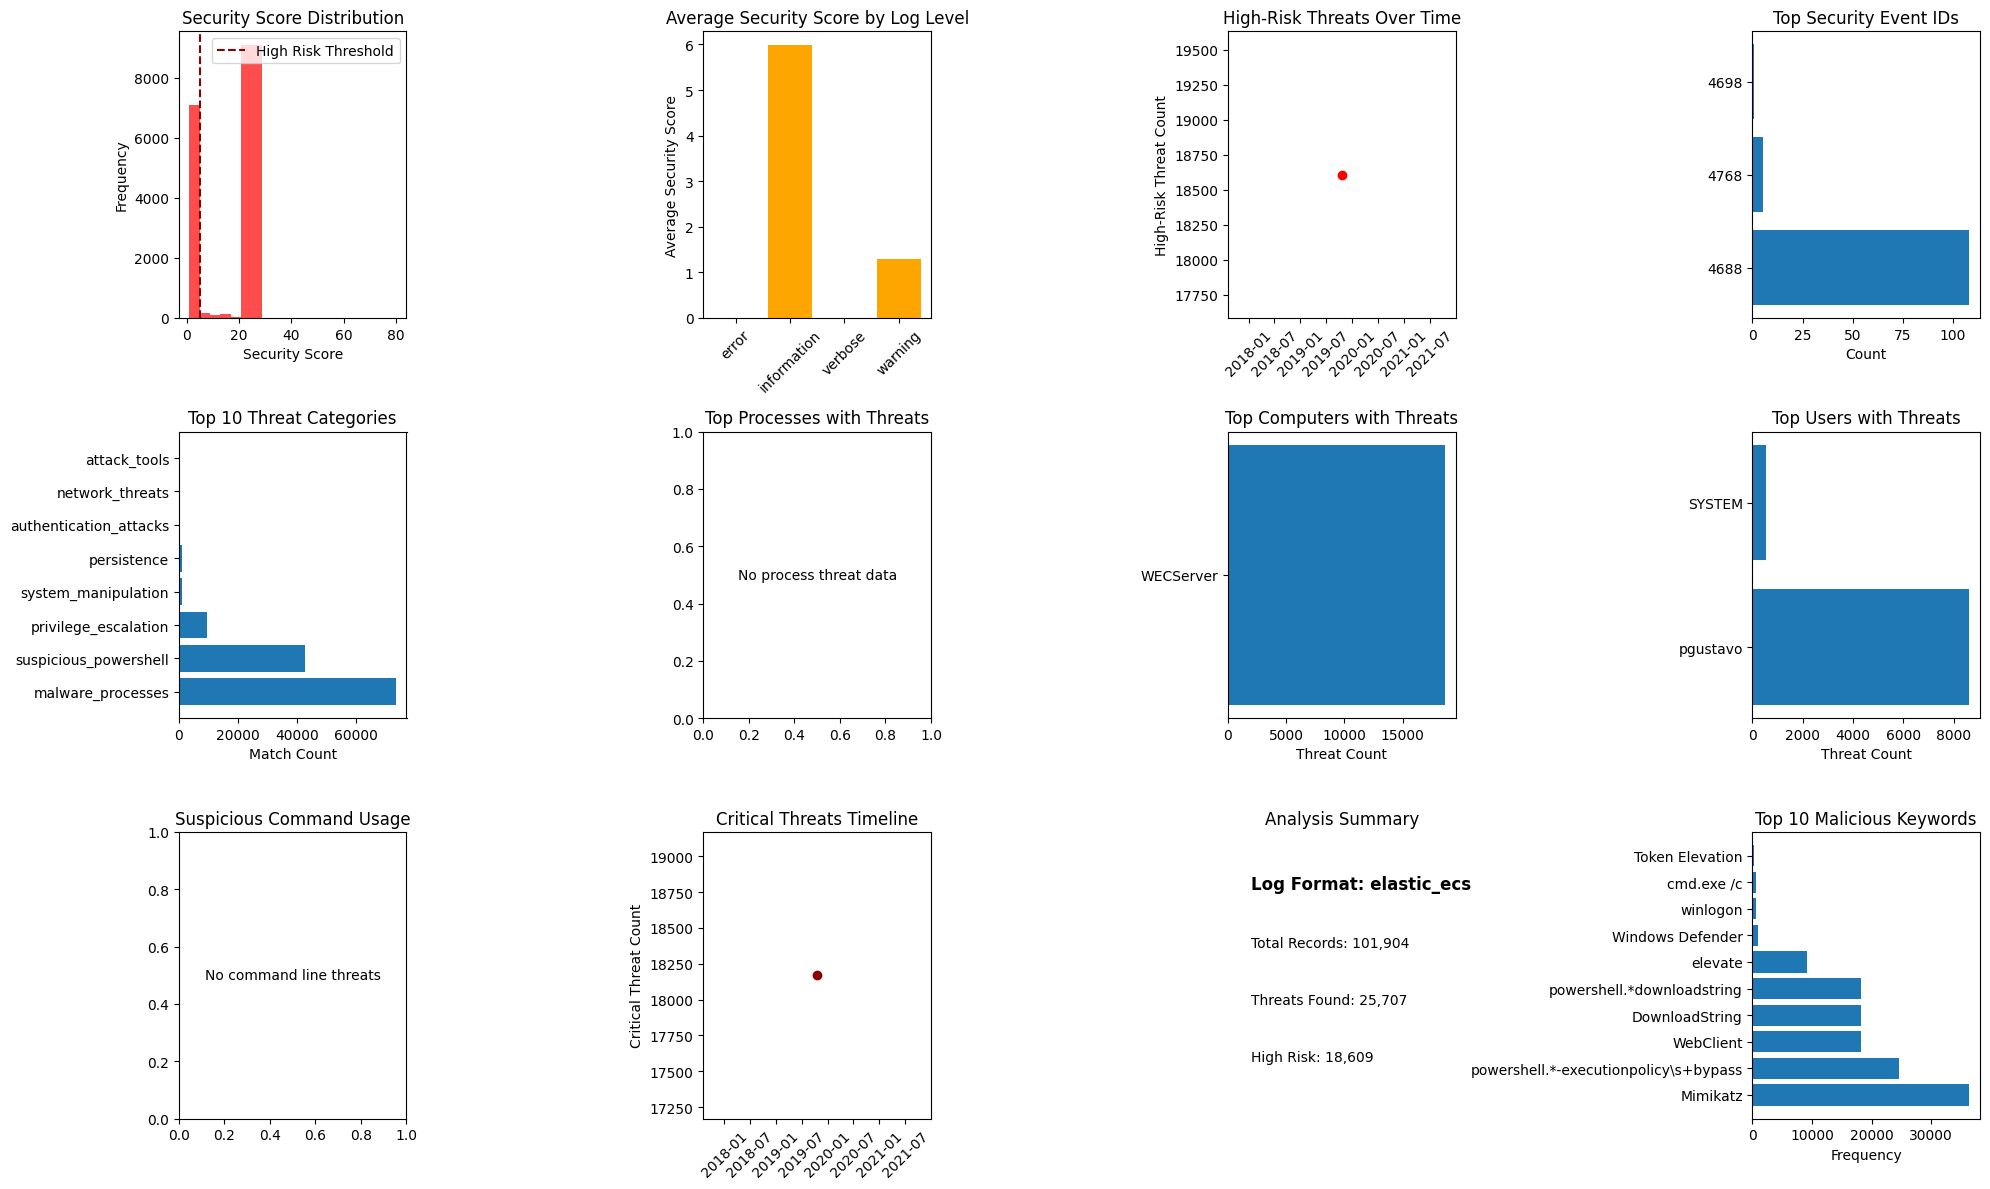


JSON SECURITY DATASETS ANALYSIS REPORT

EXECUTIVE SUMMARY:
- Log Format: elastic_ecs
- Analysis Period: 2019-10-20 20:11:06.937000 to 2019-10-20 20:23:18.866000
- Total Log Entries: 101,904
- Entries with Security Indicators: 25,707 (25.2%)
- High-Risk Entries: 18,609 (18.3%)
- Critical Priority Threats: 18,170 (17.8%)

DATASET CHARACTERISTICS:
- Unique Event IDs: 109
- Unique Sources/Components: 28
- Unique Computers: 1
- Unique Users: 4

TOP SECURITY THREATS:
1. EventID: 4104 | Score: 80 | Level: warning
   Computer: WECServer
   Threats: ['malware_processes', 'privilege_escalation']
2. EventID: 800 | Score: 62 | Level: information
   Computer: WECServer
   Threats: ['malware_processes', 'privilege_escalation', 'suspicious_powershell']
3. EventID: 800 | Score: 59 | Level: information
   Computer: WECServer
   Threats: ['malware_processes', 'privilege_escalation', 'suspicious_powershell']
4. EventID: 800 | Score: 53 | Level: information
   Computer: WECServer
   Threats: ['malware_pr

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import json
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Security Keywords and Patterns (same as before)
MALICIOUS_KEYWORDS = {
    'authentication_attacks': [
        'brute force', 'bruteforce', 'failed login', 'authentication failed',
        'invalid credentials', 'logon failure', 'account locked', 'password spray',
        'credential stuffing', 'multiple failed', 'repeated login', 'unauthorized access',
        'privilege escalation', 'token manipulation', 'impersonation',
        'pass the hash', 'pass the ticket', 'golden ticket', 'silver ticket'
    ],
    
    'malware_processes': [
        'powershell.exe -enc', 'powershell -encodedcommand', 'powershell -windowstyle hidden',
        'cmd.exe /c', 'rundll32', 'regsvr32', 'mshta', 'wscript', 'cscript',
        'bitsadmin', 'certutil', 'powershell iex', 'invoke-expression',
        'downloadstring', 'downloadfile', 'webclient', 'base64', 'gzip',
        'mimikatz', 'metasploit', 'cobalt strike', 'beacon', 'shellcode',
        'payload', 'dropper', 'backdoor', 'trojan', 'ransomware', 'cryptolocker'
    ],
    
    'network_threats': [
        'suspicious outbound', 'dns tunneling', 'command and control', 'c2 server',
        'exfiltration', 'data transfer', 'unusual traffic', 'tor browser',
        'proxy connection', 'vpn bypass', 'port scanning', 'network reconnaissance',
        'lateral movement', 'remote desktop', 'psexec', 'wmi execution',
        'smb share', 'admin shares', 'c$', 'ipc$', 'suspicious ip'
    ],
    
    'file_system_attacks': [
        'file encrypted', 'ransom note', 'readme.txt', 'decrypt_instruction',
        'suspicious file creation', 'temp file execution', 'startup folder',
        'autorun.inf', 'registry modification', 'run key', 'runonce',
        'services registry', 'file deletion', 'log clearing', 'evidence removal',
        'shadow copy delete', 'vssadmin delete', 'bcdedit', 'system restore disabled'
    ],
    
    'persistence': [
        'scheduled task', 'schtasks', 'at command', 'startup script',
        'logon script', 'service installation', 'dll hijacking', 'dll injection',
        'process hollowing', 'winlogon', 'userinit', 'shell value',
        'wmi persistence', 'com hijacking', 'registry autostart'
    ],
    
    'privilege_escalation': [
        'uac bypass', 'token elevation', 'exploit', 'vulnerability',
        'local privilege escalation', 'admin privileges', 'system privileges',
        'runas', 'elevate', 'privilege abuse', 'service account abuse',
        'weak permissions', 'dll search order', 'unquoted service path'
    ],
    
    'data_exfiltration': [
        'sensitive data', 'confidential', 'personal information', 'credit card',
        'social security', 'password dump', 'credential theft', 'keylogger',
        'screen capture', 'clipboard', 'email exfiltration', 'database dump',
        'file compression', 'archive creation', 'encrypted archive', 'ftp upload',
        'cloud storage', 'large file transfer', 'suspicious volume'
    ],
    
    'system_manipulation': [
        'system file modification', 'critical system', 'bootkit', 'rootkit',
        'kernel modification', 'driver installation', 'unsigned driver',
        'system call hook', 'api hook', 'process injection', 'memory manipulation',
        'antivirus disabled', 'security software', 'firewall disabled',
        'windows defender', 'real-time protection'
    ],
    
    'log_manipulation': [
        'event log cleared', 'log deletion', 'audit policy', 'logging disabled',
        'wevtutil', 'clear-eventlog', 'log tampering', 'audit trail',
        'security log', 'system log cleared', 'application log cleared'
    ],
    
    'attack_tools': [
        'nmap', 'netcat', 'wireshark', 'aircrack', 'hashcat', 'john',
        'hydra', 'sqlmap', 'nessus', 'metasploit', 'armitage',
        'empire', 'covenant', 'psexec', 'wmiexec', 'smbexec',
        'impacket', 'bloodhound', 'sharphound', 'rubeus', 'ghostpack'
    ]
}

HIGH_PRIORITY_INDICATORS = [
    'mimikatz', 'metasploit', 'cobalt strike', 'ransomware', 'cryptolocker',
    'golden ticket', 'silver ticket', 'pass the hash', 'credential dump',
    'event log cleared', 'security log cleared', 'antivirus disabled',
    'shadow copy delete', 'system restore disabled', 'privilege escalation',
    'unauthorized access', 'brute force', 'failed login', 'account locked'
]

POWERSHELL_SUSPICIOUS_PATTERNS = [
    r'powershell.*-enc\s+[A-Za-z0-9+/=]+',
    r'powershell.*-e\s+[A-Za-z0-9+/=]+',
    r'powershell.*invoke-expression',
    r'powershell.*iex\s*\(',
    r'powershell.*downloadstring',
    r'powershell.*-windowstyle\s+hidden',
    r'powershell.*-noprofile',
    r'powershell.*-executionpolicy\s+bypass',
    r'powershell.*frombase64string',
    r'powershell.*compress.*gzip',
]

COMMAND_LINE_PATTERNS = [
    r'cmd\.exe.*\/c.*echo.*>.*\.bat',
    r'rundll32\.exe.*javascript:',
    r'regsvr32\.exe.*\/s.*\/u.*\/i:',
    r'mshta\.exe.*http',
    r'certutil\.exe.*-urlcache.*-split',
    r'bitsadmin\.exe.*\/transfer',
    r'wmic\.exe.*process.*call.*create',
    r'schtasks\.exe.*\/create',
]

SECURITY_EVENT_IDS = {
    4625: 'Failed logon attempt',
    4648: 'Logon using explicit credentials',
    4688: 'Process creation',
    4697: 'Service installation',
    4698: 'Scheduled task created',
    4719: 'System audit policy changed',
    4720: 'User account created',
    4740: 'User account locked',
    4768: 'Kerberos ticket requested',
    4771: 'Kerberos pre-authentication failed',
    7034: 'Service crashed unexpectedly',
    7040: 'Service start type changed'
}

# Field mapping for different JSON log formats
FIELD_MAPPINGS = {
    'windows_event_log': {
        'timestamp': ['@timestamp', 'TimeCreated', 'timestamp', 'time_created'],
        'event_id': ['EventID', 'event_id', 'winlog.event_id', 'event.code'],
        'level': ['Level', 'level', 'winlog.level', 'log.level'],
        'source': ['Source', 'source', 'source_name', 'winlog.source_name', 'winlog.provider_name'],
        'message': ['Message', 'message', 'winlog.message', 'event.original'],
        'computer': ['Computer', 'computer', 'winlog.computer_name', 'host.name'],
        'user': ['User', 'user', 'winlog.user.name', 'user.name'],
        'process': ['ProcessName', 'process_name', 'winlog.process.name', 'process.name'],
        'command_line': ['CommandLine', 'command_line', 'winlog.command_line', 'process.command_line']
    },
    'sysmon': {
        'timestamp': ['@timestamp', 'UtcTime', 'timestamp'],
        'event_id': ['EventID', 'event_id'],
        'level': ['Level', 'level'],
        'source': ['Source', 'source'],
        'message': ['Message', 'message'],
        'computer': ['Computer', 'computer'],
        'process': ['Image', 'ProcessName', 'process_name'],
        'command_line': ['CommandLine', 'command_line'],
        'parent_process': ['ParentImage', 'parent_process'],
        'user': ['User', 'user']
    },
    'elastic_ecs': {
        'timestamp': ['@timestamp', 'timestamp'],
        'event_id': ['event.code', 'winlog.event_id'],
        'level': ['log.level', 'winlog.level'],
        'source': ['winlog.provider_name', 'source.name'],
        'message': ['message', 'winlog.message'],
        'computer': ['host.name', 'winlog.computer_name'],
        'user': ['user.name', 'winlog.user.name'],
        'process': ['process.name', 'winlog.process.name'],
        'command_line': ['process.command_line', 'winlog.command_line']
    }
}

class JSONSecurityLogAnalyzer:
    def __init__(self, json_file_path, log_format='auto'):
        """
        Initialize the JSON Security Log Analyzer for SecurityDatasets.com
        
        Args:
            json_file_path (str): Path to the JSON file or directory containing JSON files
            log_format (str): Log format type ('windows_event_log', 'sysmon', 'elastic_ecs', 'auto')
        """
        self.json_file_path = json_file_path
        self.log_format = log_format
        self.df = None
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.processed_content = None
        
        # Security analysis components
        self.security_patterns = self._create_security_patterns()
        self.security_analyzed = False
        
        # Load and prepare the data
        self._load_json_data()
        self._prepare_data()
    
    def _create_security_patterns(self):
        """Create compiled regex patterns for security analysis"""
        patterns = {}
        for category, keywords in MALICIOUS_KEYWORDS.items():
            pattern = r'\b(' + '|'.join(re.escape(keyword) for keyword in keywords) + r')\b'
            patterns[category] = re.compile(pattern, re.IGNORECASE)
        return patterns
    
    def _detect_log_format(self, sample_records):
        """Auto-detect the log format based on sample records"""
        if not sample_records:
            return 'windows_event_log'
        
        sample = sample_records[0] if isinstance(sample_records, list) else sample_records
        
        # Check for Sysmon indicators
        if any(field in sample for field in ['UtcTime', 'Image', 'ParentImage']):
            return 'sysmon'
        
        # Check for Elastic ECS format
        if any(field in sample for field in ['@timestamp', 'event.code', 'winlog.event_id']):
            return 'elastic_ecs'
        
        # Default to Windows Event Log
        return 'windows_event_log'
    
    def _find_field_value(self, record, field_options):
        """Find the first available field value from a list of possible field names"""
        for field in field_options:
            if field in record:
                return record[field]
            # Handle nested fields (e.g., 'winlog.event_id')
            if '.' in field:
                nested_value = record
                for part in field.split('.'):
                    if isinstance(nested_value, dict) and part in nested_value:
                        nested_value = nested_value[part]
                    else:
                        nested_value = None
                        break
                if nested_value is not None:
                    return nested_value
        return None
    
    def _load_json_data(self):
        """Load JSON data from file or directory"""
        print(f"Loading JSON data from: {self.json_file_path}")
        
        json_records = []
        
        # Handle directory or single file
        if os.path.isdir(self.json_file_path):
            # Load all JSON files in directory
            json_files = list(Path(self.json_file_path).glob('*.json'))
            print(f"Found {len(json_files)} JSON files in directory")
            
            for json_file in json_files[:10]:  # Limit to first 10 files for performance
                print(f"Loading: {json_file.name}")
                try:
                    with open(json_file, 'r', encoding='utf-8') as f:
                        # Handle both single JSON objects and NDJSON (newline-delimited JSON)
                        content = f.read().strip()
                        if content.startswith('['):
                            # JSON array
                            data = json.loads(content)
                            json_records.extend(data if isinstance(data, list) else [data])
                        else:
                            # NDJSON format
                            for line in content.split('\n'):
                                if line.strip():
                                    try:
                                        json_records.append(json.loads(line))
                                    except json.JSONDecodeError:
                                        continue
                except Exception as e:
                    print(f"Error loading {json_file}: {e}")
                    continue
        else:
            # Single JSON file
            try:
                with open(self.json_file_path, 'r', encoding='utf-8') as f:
                    content = f.read().strip()
                    if content.startswith('['):
                        # JSON array
                        data = json.loads(content)
                        json_records.extend(data if isinstance(data, list) else [data])
                    else:
                        # NDJSON format
                        for line in content.split('\n'):
                            if line.strip():
                                try:
                                    json_records.append(json.loads(line))
                                except json.JSONDecodeError:
                                    continue
            except Exception as e:
                print(f"Error loading JSON file: {e}")
                return
        
        if not json_records:
            print("No JSON records found")
            return
        
        print(f"Loaded {len(json_records)} JSON records")
        
        # Auto-detect format if needed
        if self.log_format == 'auto':
            self.log_format = self._detect_log_format(json_records[:5])
            print(f"Auto-detected log format: {self.log_format}")
        
        # Convert to DataFrame
        self._convert_to_dataframe(json_records)
    
    def _convert_to_dataframe(self, json_records):
        """Convert JSON records to standardized DataFrame"""
        field_mapping = FIELD_MAPPINGS.get(self.log_format, FIELD_MAPPINGS['windows_event_log'])
        
        converted_records = []
        
        for record in json_records:
            converted_record = {
                'LineId': len(converted_records) + 1,
                'DateTime': None,
                'Date': None,
                'Time': None,
                'Level': None,
                'Component': None,
                'Content': None,
                'EventId': None,
                'Computer': None,
                'User': None,
                'Process': None,
                'CommandLine': None,
                'OriginalRecord': record  # Keep original for reference
            }
            
            # Extract timestamp
            timestamp_value = self._find_field_value(record, field_mapping['timestamp'])
            if timestamp_value:
                try:
                    if isinstance(timestamp_value, str):
                        # Try different datetime formats
                        for fmt in ['%Y-%m-%dT%H:%M:%S.%fZ', '%Y-%m-%dT%H:%M:%SZ', 
                                   '%Y-%m-%d %H:%M:%S.%f', '%Y-%m-%d %H:%M:%S']:
                            try:
                                dt = datetime.strptime(timestamp_value, fmt)
                                converted_record['DateTime'] = dt
                                converted_record['Date'] = dt.strftime('%Y-%m-%d')
                                converted_record['Time'] = dt.strftime('%H:%M:%S')
                                break
                            except ValueError:
                                continue
                    elif isinstance(timestamp_value, (int, float)):
                        dt = datetime.fromtimestamp(timestamp_value)
                        converted_record['DateTime'] = dt
                        converted_record['Date'] = dt.strftime('%Y-%m-%d')
                        converted_record['Time'] = dt.strftime('%H:%M:%S')
                except Exception:
                    pass
            
            # Extract other fields
            converted_record['EventId'] = self._find_field_value(record, field_mapping['event_id'])
            converted_record['Level'] = self._find_field_value(record, field_mapping['level'])
            converted_record['Component'] = self._find_field_value(record, field_mapping['source'])
            converted_record['Computer'] = self._find_field_value(record, field_mapping['computer'])
            converted_record['User'] = self._find_field_value(record, field_mapping['user'])
            converted_record['Process'] = self._find_field_value(record, field_mapping['process'])
            converted_record['CommandLine'] = self._find_field_value(record, field_mapping['command_line'])
            
            # Build content from message and other relevant fields
            content_parts = []
            message = self._find_field_value(record, field_mapping['message'])
            if message:
                content_parts.append(str(message))
            
            # Add command line if available
            if converted_record['CommandLine']:
                content_parts.append(f"CommandLine: {converted_record['CommandLine']}")
            
            # Add process if available
            if converted_record['Process']:
                content_parts.append(f"Process: {converted_record['Process']}")
            
            converted_record['Content'] = ' | '.join(content_parts) if content_parts else ''
            
            converted_records.append(converted_record)
        
        self.df = pd.DataFrame(converted_records)
        print(f"Converted to DataFrame with {len(self.df)} records")
    
    def _prepare_data(self):
        """Prepare and clean the log data"""
        if self.df is None or len(self.df) == 0:
            print("No data to prepare")
            return
        
        # Handle datetime
        if 'DateTime' not in self.df.columns or self.df['DateTime'].isna().all():
            # Fallback: create datetime from Date and Time if available
            if 'Date' in self.df.columns and 'Time' in self.df.columns:
                try:
                    self.df['datetime'] = pd.to_datetime(self.df['Date'] + ' ' + self.df['Time'], errors='coerce')
                except:
                    self.df['datetime'] = pd.Timestamp.now()
            else:
                self.df['datetime'] = pd.Timestamp.now()
        else:
            self.df['datetime'] = pd.to_datetime(self.df['DateTime'], errors='coerce')
        
        # Fill missing values
        self.df['Content'] = self.df['Content'].fillna('')
        self.df['Component'] = self.df['Component'].fillna('Unknown')
        self.df['Level'] = self.df['Level'].fillna('Info')
        self.df['EventId'] = self.df['EventId'].fillna('0').astype(str)
        
        # Create Date and Time columns if missing
        if 'Date' not in self.df.columns or self.df['Date'].isna().all():
            self.df['Date'] = self.df['datetime'].dt.strftime('%Y-%m-%d')
        if 'Time' not in self.df.columns or self.df['Time'].isna().all():
            self.df['Time'] = self.df['datetime'].dt.strftime('%H:%M:%S')
        
        print(f"Prepared {len(self.df)} log entries")
        print(f"Date range: {self.df['datetime'].min()} to {self.df['datetime'].max()}")
        print(f"Log levels: {self.df['Level'].value_counts().to_dict()}")
        print(f"Top components: {self.df['Component'].value_counts().head().to_dict()}")
    
    def preprocess_text(self, text):
        """Preprocess log content for NLP analysis"""
        if pd.isna(text) or text == '':
            return ''
        
        text = text.lower()
        text = re.sub(r'[^\w\s\-\.]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 2]
        tokens = [self.stemmer.stem(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def score_security_threats(self, log_content):
        """Score a log entry based on malicious keyword presence"""
        if not log_content or pd.isna(log_content):
            return {'total_score': 0, 'matches': {}, 'high_priority': False}
        
        results = {'total_score': 0, 'matches': {}, 'high_priority': False}
        
        # Check each category
        for category, pattern in self.security_patterns.items():
            matches = pattern.findall(log_content)
            if matches:
                results['matches'][category] = matches
                if category in ['authentication_attacks', 'malware_processes', 'privilege_escalation']:
                    results['total_score'] += len(matches) * 3
                else:
                    results['total_score'] += len(matches)
        
        # Check PowerShell patterns
        if 'powershell' in log_content.lower():
            ps_matches = []
            for pattern in POWERSHELL_SUSPICIOUS_PATTERNS:
                if re.search(pattern, log_content, re.IGNORECASE):
                    ps_matches.append(pattern)
            if ps_matches:
                results['matches']['suspicious_powershell'] = ps_matches
                results['total_score'] += len(ps_matches) * 3
        
        # Check command line patterns
        cmd_matches = []
        for pattern in COMMAND_LINE_PATTERNS:
            if re.search(pattern, log_content, re.IGNORECASE):
                cmd_matches.append(pattern)
        if cmd_matches:
            results['matches']['suspicious_commands'] = cmd_matches
            results['total_score'] += len(cmd_matches) * 3
        
        # Check for high-priority indicators
        content_lower = log_content.lower()
        for indicator in HIGH_PRIORITY_INDICATORS:
            if indicator.lower() in content_lower:
                results['high_priority'] = True
                results['total_score'] += 5
                break
        
        return results
    
    def analyze_security_threats(self):
        """Perform comprehensive security threat analysis"""
        print("\n=== SECURITY THREAT ANALYSIS ===")
        
        if self.df is None or len(self.df) == 0:
            print("No data available for security analysis")
            return
        
        # Score each log entry
        security_scores = []
        threat_matches = []
        high_priority_flags = []
        
        for idx, row in self.df.iterrows():
            content = str(row.get('Content', ''))
            # Also check CommandLine field specifically
            if 'CommandLine' in row and pd.notna(row['CommandLine']):
                content += f" {row['CommandLine']}"
            
            score_result = self.score_security_threats(content)
            
            security_scores.append(score_result['total_score'])
            threat_matches.append(score_result['matches'])
            high_priority_flags.append(score_result['high_priority'])
        
        # Add to dataframe
        self.df['security_score'] = security_scores
        self.df['threat_matches'] = threat_matches
        self.df['high_priority_threat'] = high_priority_flags
        self.df['high_risk'] = self.df['security_score'] >= 5
        
        self.security_analyzed = True
        
        # Summary statistics
        total_threats = len(self.df[self.df['security_score'] > 0])
        high_risk_threats = len(self.df[self.df['high_risk']])
        critical_threats = len(self.df[self.df['high_priority_threat']])
        
        print(f"Security Analysis Results:")
        print(f"- Total entries with security indicators: {total_threats} ({total_threats/len(self.df)*100:.1f}%)")
        print(f"- High-risk entries (score ≥5): {high_risk_threats} ({high_risk_threats/len(self.df)*100:.1f}%)")
        print(f"- Critical priority threats: {critical_threats} ({critical_threats/len(self.df)*100:.1f}%)")
        
        # Show top threats
        if high_risk_threats > 0:
            print("\nTop 10 highest risk security threats:")
            top_threats = self.df[self.df['high_risk']].nlargest(10, 'security_score')
            for idx, row in top_threats.iterrows():
                print(f"LineId: {row['LineId']}, Score: {row['security_score']}, Level: {row['Level']}")
                print(f"EventID: {row['EventId']}, Component: {row['Component']}")
                if 'Process' in row and pd.notna(row['Process']):
                    print(f"Process: {row['Process']}")
                if 'CommandLine' in row and pd.notna(row['CommandLine']):
                    print(f"CommandLine: {row['CommandLine'][:100]}...")
                print(f"Content: {row['Content'][:100]}...")
                if row['threat_matches']:
                    print(f"Threats: {list(row['threat_matches'].keys())}")
                print()
        
        # Visualize security threats
        self._visualize_security_threats()
    
    def _visualize_security_threats(self):
        """Create visualizations for security threat analysis"""
        if not self.security_analyzed:
            print("Run analyze_security_threats() first")
            return
        
        plt.figure(figsize=(20, 12))
        
        # Security score distribution
        plt.subplot(3, 4, 1)
        threat_logs = self.df[self.df['security_score'] > 0]
        if len(threat_logs) > 0:
            plt.hist(threat_logs['security_score'], bins=20, alpha=0.7, color='red')
            plt.axvline(5, color='darkred', linestyle='--', label='High Risk Threshold')
            plt.title('Security Score Distribution')
            plt.xlabel('Security Score')
            plt.ylabel('Frequency')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No security threats detected', ha='center', va='center')
            plt.title('Security Score Distribution')
        
        # Threats by log level
        plt.subplot(3, 4, 2)
        threat_by_level = self.df.groupby('Level')['security_score'].mean()
        if len(threat_by_level) > 0:
            plt.bar(threat_by_level.index, threat_by_level.values, color='orange')
            plt.title('Average Security Score by Log Level')
            plt.ylabel('Average Security Score')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data available', ha='center', va='center')
            plt.title('Average Security Score by Log Level')
        
        # Threats over time
        plt.subplot(3, 4, 3)
        if 'datetime' in self.df.columns:
            daily_threats = self.df[self.df['high_risk']].groupby(self.df['datetime'].dt.date).size()
            if len(daily_threats) > 0:
                plt.plot(daily_threats.index, daily_threats.values, marker='o', color='red')
                plt.title('High-Risk Threats Over Time')
                plt.xticks(rotation=45)
                plt.ylabel('High-Risk Threat Count')
            else:
                plt.text(0.5, 0.5, 'No high-risk threats over time', ha='center', va='center')
                plt.title('High-Risk Threats Over Time')
        else:
            plt.text(0.5, 0.5, 'No datetime data', ha='center', va='center')
            plt.title('High-Risk Threats Over Time')
        
        # Security Event IDs
        plt.subplot(3, 4, 4)
        security_event_ids = []
        for event_id in self.df['EventId']:
            try:
                if int(event_id) in SECURITY_EVENT_IDS:
                    security_event_ids.append(event_id)
            except (ValueError, TypeError):
                continue
        
        if security_event_ids:
            event_counts = pd.Series(security_event_ids).value_counts().head(10)
            if len(event_counts) > 0:
                plt.barh(range(len(event_counts)), event_counts.values)
                plt.yticks(range(len(event_counts)), 
                          [f"{eid}" for eid in event_counts.index])
                plt.title('Top Security Event IDs')
                plt.xlabel('Count')
            else:
                plt.text(0.5, 0.5, 'No security event data', ha='center', va='center')
                plt.title('Top Security Event IDs')
        else:
            plt.text(0.5, 0.5, 'No security events found', ha='center', va='center')
            plt.title('Top Security Event IDs')
        
        # Top threat categories
        plt.subplot(3, 4, 5)
        threat_categories = {}
        for matches_list in self.df['threat_matches']:
            for category, matches in matches_list.items():
                threat_categories[category] = threat_categories.get(category, 0) + len(matches)
        
        if threat_categories:
            sorted_categories = sorted(threat_categories.items(), key=lambda x: x[1], reverse=True)[:10]
            if sorted_categories:
                categories, counts = zip(*sorted_categories)
                plt.barh(range(len(categories)), counts)
                plt.yticks(range(len(categories)), categories)
                plt.title('Top 10 Threat Categories')
                plt.xlabel('Match Count')
            else:
                plt.text(0.5, 0.5, 'No threat categories found', ha='center', va='center')
                plt.title('Top 10 Threat Categories')
        else:
            plt.text(0.5, 0.5, 'No threat categories found', ha='center', va='center')
            plt.title('Top 10 Threat Categories')
        
        # Process-based threats
        plt.subplot(3, 4, 6)
        if 'Process' in self.df.columns:
            process_threats = self.df[self.df['high_risk']]['Process'].value_counts().head(10)
            if len(process_threats) > 0:
                plt.barh(range(len(process_threats)), process_threats.values)
                plt.yticks(range(len(process_threats)), process_threats.index)
                plt.title('Top Processes with Threats')
                plt.xlabel('Threat Count')
            else:
                plt.text(0.5, 0.5, 'No process threat data', ha='center', va='center')
                plt.title('Top Processes with Threats')
        else:
            plt.text(0.5, 0.5, 'No process data available', ha='center', va='center')
            plt.title('Top Processes with Threats')
        
        # Computer-based threats
        plt.subplot(3, 4, 7)
        if 'Computer' in self.df.columns:
            computer_threats = self.df[self.df['high_risk']]['Computer'].value_counts().head(10)
            if len(computer_threats) > 0:
                plt.barh(range(len(computer_threats)), computer_threats.values)
                plt.yticks(range(len(computer_threats)), computer_threats.index)
                plt.title('Top Computers with Threats')
                plt.xlabel('Threat Count')
            else:
                plt.text(0.5, 0.5, 'No computer threat data', ha='center', va='center')
                plt.title('Top Computers with Threats')
        else:
            plt.text(0.5, 0.5, 'No computer data available', ha='center', va='center')
            plt.title('Top Computers with Threats')
        
        # User-based threats
        plt.subplot(3, 4, 8)
        if 'User' in self.df.columns:
            user_threats = self.df[self.df['high_risk'] & self.df['User'].notna()]['User'].value_counts().head(10)
            if len(user_threats) > 0:
                plt.barh(range(len(user_threats)), user_threats.values)
                plt.yticks(range(len(user_threats)), user_threats.index)
                plt.title('Top Users with Threats')
                plt.xlabel('Threat Count')
            else:
                plt.text(0.5, 0.5, 'No user threat data', ha='center', va='center')
                plt.title('Top Users with Threats')
        else:
            plt.text(0.5, 0.5, 'No user data available', ha='center', va='center')
            plt.title('Top Users with Threats')
        
        # Command line analysis
        plt.subplot(3, 4, 9)
        if 'CommandLine' in self.df.columns:
            cmdline_threats = self.df[self.df['high_risk'] & self.df['CommandLine'].notna()]
            if len(cmdline_threats) > 0:
                # Extract common command patterns
                cmdlines = cmdline_threats['CommandLine'].str.lower()
                common_commands = []
                for cmd in ['powershell', 'cmd', 'rundll32', 'regsvr32', 'certutil']:
                    count = cmdlines.str.contains(cmd, na=False).sum()
                    if count > 0:
                        common_commands.append((cmd, count))
                
                if common_commands:
                    commands, counts = zip(*common_commands)
                    plt.bar(commands, counts)
                    plt.title('Suspicious Command Usage')
                    plt.xlabel('Command')
                    plt.ylabel('Count')
                    plt.xticks(rotation=45)
                else:
                    plt.text(0.5, 0.5, 'No command patterns found', ha='center', va='center')
                    plt.title('Suspicious Command Usage')
            else:
                plt.text(0.5, 0.5, 'No command line threats', ha='center', va='center')
                plt.title('Suspicious Command Usage')
        else:
            plt.text(0.5, 0.5, 'No command line data', ha='center', va='center')
            plt.title('Suspicious Command Usage')
        
        # Timeline of critical events
        plt.subplot(3, 4, 10)
        critical_events = self.df[self.df['high_priority_threat']]
        if len(critical_events) > 0 and 'datetime' in self.df.columns:
            daily_critical = critical_events.groupby(critical_events['datetime'].dt.date).size()
            if len(daily_critical) > 0:
                plt.plot(daily_critical.index, daily_critical.values, marker='o', color='darkred')
                plt.title('Critical Threats Timeline')
                plt.xticks(rotation=45)
                plt.ylabel('Critical Threat Count')
            else:
                plt.text(0.5, 0.5, 'No daily critical data', ha='center', va='center')
                plt.title('Critical Threats Timeline')
        else:
            plt.text(0.5, 0.5, 'No critical threats found', ha='center', va='center')
            plt.title('Critical Threats Timeline')
        
        # Log format summary
        plt.subplot(3, 4, 11)
        plt.text(0.1, 0.8, f'Log Format: {self.log_format}', fontsize=12, fontweight='bold')
        plt.text(0.1, 0.6, f'Total Records: {len(self.df):,}', fontsize=10)
        plt.text(0.1, 0.4, f'Threats Found: {len(self.df[self.df["security_score"] > 0]):,}', fontsize=10)
        plt.text(0.1, 0.2, f'High Risk: {len(self.df[self.df["high_risk"]]):,}', fontsize=10)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        plt.title('Analysis Summary')
        
        # Top malicious keywords
        plt.subplot(3, 4, 12)
        all_keywords = {}
        for matches_list in self.df['threat_matches']:
            for category, matches in matches_list.items():
                for match in matches:
                    if isinstance(match, str):
                        all_keywords[match] = all_keywords.get(match, 0) + 1
        
        if all_keywords:
            top_keywords = sorted(all_keywords.items(), key=lambda x: x[1], reverse=True)[:10]
            if top_keywords:
                keywords, counts = zip(*top_keywords)
                plt.barh(range(len(keywords)), counts)
                plt.yticks(range(len(keywords)), keywords)
                plt.title('Top 10 Malicious Keywords')
                plt.xlabel('Frequency')
            else:
                plt.text(0.5, 0.5, 'No keywords found', ha='center', va='center')
                plt.title('Top 10 Malicious Keywords')
        else:
            plt.text(0.5, 0.5, 'No malicious keywords detected', ha='center', va='center')
            plt.title('Top 10 Malicious Keywords')
        
        plt.tight_layout()
        plt.show()
    
    def generate_security_report(self):
        """Generate a comprehensive security report"""
        if not self.security_analyzed:
            print("Run analyze_security_threats() first")
            return
        
        print("\n" + "="*80)
        print("JSON SECURITY DATASETS ANALYSIS REPORT")
        print("="*80)
        
        # Executive Summary
        total_entries = len(self.df)
        threat_entries = len(self.df[self.df['security_score'] > 0])
        high_risk_entries = len(self.df[self.df['high_risk']])
        critical_entries = len(self.df[self.df['high_priority_threat']])
        
        print(f"\nEXECUTIVE SUMMARY:")
        print(f"- Log Format: {self.log_format}")
        print(f"- Analysis Period: {self.df['datetime'].min()} to {self.df['datetime'].max()}")
        print(f"- Total Log Entries: {total_entries:,}")
        print(f"- Entries with Security Indicators: {threat_entries:,} ({threat_entries/total_entries*100:.1f}%)")
        print(f"- High-Risk Entries: {high_risk_entries:,} ({high_risk_entries/total_entries*100:.1f}%)")
        print(f"- Critical Priority Threats: {critical_entries:,} ({critical_entries/total_entries*100:.1f}%)")
        
        # Dataset characteristics
        print(f"\nDATASET CHARACTERISTICS:")
        print(f"- Unique Event IDs: {self.df['EventId'].nunique()}")
        print(f"- Unique Sources/Components: {self.df['Component'].nunique()}")
        if 'Computer' in self.df.columns:
            print(f"- Unique Computers: {self.df['Computer'].nunique()}")
        if 'User' in self.df.columns:
            print(f"- Unique Users: {self.df['User'].nunique()}")
        
        # Top Threats
        if high_risk_entries > 0:
            print(f"\nTOP SECURITY THREATS:")
            top_threats = self.df[self.df['high_risk']].nlargest(5, 'security_score')
            for i, (idx, row) in enumerate(top_threats.iterrows(), 1):
                print(f"{i}. EventID: {row['EventId']} | Score: {row['security_score']} | Level: {row['Level']}")
                if 'Computer' in row and pd.notna(row['Computer']):
                    print(f"   Computer: {row['Computer']}")
                if 'Process' in row and pd.notna(row['Process']):
                    print(f"   Process: {row['Process']}")
                if 'CommandLine' in row and pd.notna(row['CommandLine']):
                    print(f"   CommandLine: {str(row['CommandLine'])[:100]}...")
                print(f"   Threats: {list(row['threat_matches'].keys())}")
        
        # Threat Categories
        print(f"\nTHREAT CATEGORIES:")
        threat_categories = {}
        for matches_list in self.df['threat_matches']:
            for category, matches in matches_list.items():
                threat_categories[category] = threat_categories.get(category, 0) + len(matches)
        
        for category, count in sorted(threat_categories.items(), key=lambda x: x[1], reverse=True):
            print(f"- {category.replace('_', ' ').title()}: {count} indicators")
        
        # Process-based analysis
        if 'Process' in self.df.columns:
            suspicious_processes = self.df[self.df['high_risk']]['Process'].value_counts().head(5)
            if len(suspicious_processes) > 0:
                print(f"\nTOP SUSPICIOUS PROCESSES:")
                for process, count in suspicious_processes.items():
                    print(f"- {process}: {count} threats")
        
        # Recommendations
        print(f"\nRECOMMENDATIONS:")
        if critical_entries > 0:
            print("🔴 CRITICAL: Immediate investigation required for high-priority threats")
        if high_risk_entries > 0:
            print("🟡 HIGH: Review and investigate high-risk entries")
        if 'authentication_attacks' in threat_categories:
            print("🔐 Implement stronger authentication controls and monitoring")
        if 'malware_processes' in threat_categories:
            print("🛡️ Review endpoint security and process monitoring")
        if 'log_manipulation' in threat_categories:
            print("📊 Strengthen log integrity and monitoring")
        
        print("\n" + "="*80)
    
    def export_threats_to_json(self, output_file='security_threats.json'):
        """Export identified threats to JSON file"""
        if not self.security_analyzed:
            print("Run analyze_security_threats() first")
            return
        
        threats = self.df[self.df['security_score'] > 0].copy()
        threat_export = []
        
        for idx, row in threats.iterrows():
            threat_record = {
                'line_id': row['LineId'],
                'timestamp': row['datetime'].isoformat() if pd.notna(row['datetime']) else None,
                'event_id': row['EventId'],
                'level': row['Level'],
                'computer': row['Computer'] if 'Computer' in row else None,
                'user': row['User'] if 'User' in row else None,
                'process': row['Process'] if 'Process' in row else None,
                'command_line': row['CommandLine'] if 'CommandLine' in row else None,
                'security_score': row['security_score'],
                'high_risk': row['high_risk'],
                'high_priority': row['high_priority_threat'],
                'threat_categories': list(row['threat_matches'].keys()),
                'content': row['Content'],
                'original_record': row['OriginalRecord']
            }
            threat_export.append(threat_record)
        
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(threat_export, f, indent=2, default=str)
        
        print(f"Exported {len(threat_export)} threats to {output_file}")

    def export_threats_to_csv(self, output_file='security_threats.csv'):
        """Export identified threats to CSV file"""
        if not self.security_analyzed:
            print("Run analyze_security_threats() first")
            return
    
        threats = self.df[self.df['security_score'] > 0].copy()
        threat_export = []
    
        for idx, row in threats.iterrows():
            threat_record = {
                'line_id': row['LineId'],
                'timestamp': row['datetime'].isoformat() if pd.notna(row['datetime']) else None,
                'event_id': row['EventId'],
                'level': row['Level'],
                'computer': row['Computer'] if 'Computer' in row else None,
                'user': row['User'] if 'User' in row else None,
                'process': row['Process'] if 'Process' in row else None,
                'command_line': row['CommandLine'] if 'CommandLine' in row else None,
                'security_score': row['security_score'],
                'high_risk': row['high_risk'],
                'high_priority': row['high_priority_threat'],
                'threat_categories': ', '.join(row['threat_matches'].keys()),  # Convert list to comma-separated string
                'content': row['Content'],
                'original_record': row['OriginalRecord']
            }
            threat_export.append(threat_record)
    
        # Convert to DataFrame and export to CSV
        df_export = pd.DataFrame(threat_export)
        df_export.to_csv(output_file, index=False, encoding='utf-8')
    
        print(f"Exported {len(threat_export)} threats to {output_file}")

# Usage examples and helper functions
def download_sample_dataset():
    """Download a sample dataset from SecurityDatasets.com for testing"""
    print("Sample datasets available at: https://securitydatasets.com/datasets/")
    print("Popular datasets:")
    print("- Empire: https://raw.githubusercontent.com/OTRF/mordor/master/datasets/small/windows/execution/empire_invoke_wmi.zip")
    print("- APT29: https://raw.githubusercontent.com/OTRF/mordor/master/datasets/small/windows/credential_access/credential_dumping_T1003/empire_dcsync.zip")
    print("- Atomic Red Team: https://raw.githubusercontent.com/OTRF/mordor/master/datasets/small/windows/execution/atomic_red_team_T1059_003.zip")

def analyze_securitydatasets_json(json_path, log_format='auto'):
    """Convenience function to analyze SecurityDatasets.com JSON files"""
    analyzer = JSONSecurityLogAnalyzer(json_path, log_format)
    
    if analyzer.df is None or len(analyzer.df) == 0:
        print("Failed to load data")
        return None
    
    # Run security analysis
    analyzer.analyze_security_threats()
    analyzer.generate_security_report()
    
    return analyzer

# Example usage
if __name__ == "__main__":
    print("JSON Security Datasets Log Analyzer")
    print("="*50)
    print("This analyzer supports JSON log files from SecurityDatasets.com")
    print("Supported formats: Windows Event Logs, Sysmon, Elastic ECS")
    print()
    
    # Example usage:
    analyzer = JSONSecurityLogAnalyzer('/Users/sfsmith/Downloads/caldera_attack_evals_round1_day1_2019-10-20201108.json')
    analyzer.analyze_security_threats()
    analyzer.generate_security_report()
    #analyzer.export_threats_to_json('threats_found.json')
    analyzer.export_threats_to_csv('threats_found.csv')
    # For directories with multiple JSON files:
    # analyzer = JSONSecurityLogAnalyzer('path/to/json/directory/')
    
    # For specific log formats:
    # analyzer = JSONSecurityLogAnalyzer('dataset.json', log_format='sysmon')
    
    #download_sample_dataset()

In [4]:
analyzer.export_threats_to_json('threats_found.json')


Exported 25707 threats to threats_found.json
